In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import xgboost as xgb
import gc
from tqdm import tqdm
from sklearn.svm import SVC
# from keras.models import Sequential
# from keras.layers.recurrent import LSTM, GRU
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.embeddings import Embedding
# from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

# from lightgbm import LGBMRegressor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
# from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
# from keras.preprocessing import sequence, text
# from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = stopwords.words('english')
import seaborn as sns
import string
import unidecode
import re
# from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('sample_sub.csv')
tags = pd.read_csv('Tags.csv')

In [4]:
tags.head(3)

,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence


# Exploratory Data Analysis

### **1. Brief look at the dataset**.

In [5]:
train.head(3)
test.head(3)
tags.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0


,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence


In [6]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

len(TARGET_COLS)

25

In [7]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n->->->| The dataset contains {len(features)} features')


->->->| Train contains 14004 samples and 31 variables

->->->| Test contains 6002 samples and 6 variables

->->->| Number of distinct SUB TOPICS is 25

->->->| The dataset contains 5 features


In [8]:
### **3.Target Distribution**
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

# EDA

In [9]:
# first make copy of the train dataframe
# elemination of 'id' and 'ABSTRACT'
# conversion to dictionary
train_data = train.copy()
f=train_data
f=f.drop('id', axis=1)
f=f.drop(['ABSTRACT'], axis=1)
di=f.sum(axis = 0, skipna = True)
f=di.to_dict()
f_keys=list(f.keys())
f_values=list(f.values())

<Figure size 1500x800 with 0 Axes>

<BarContainer object of 29 artists>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

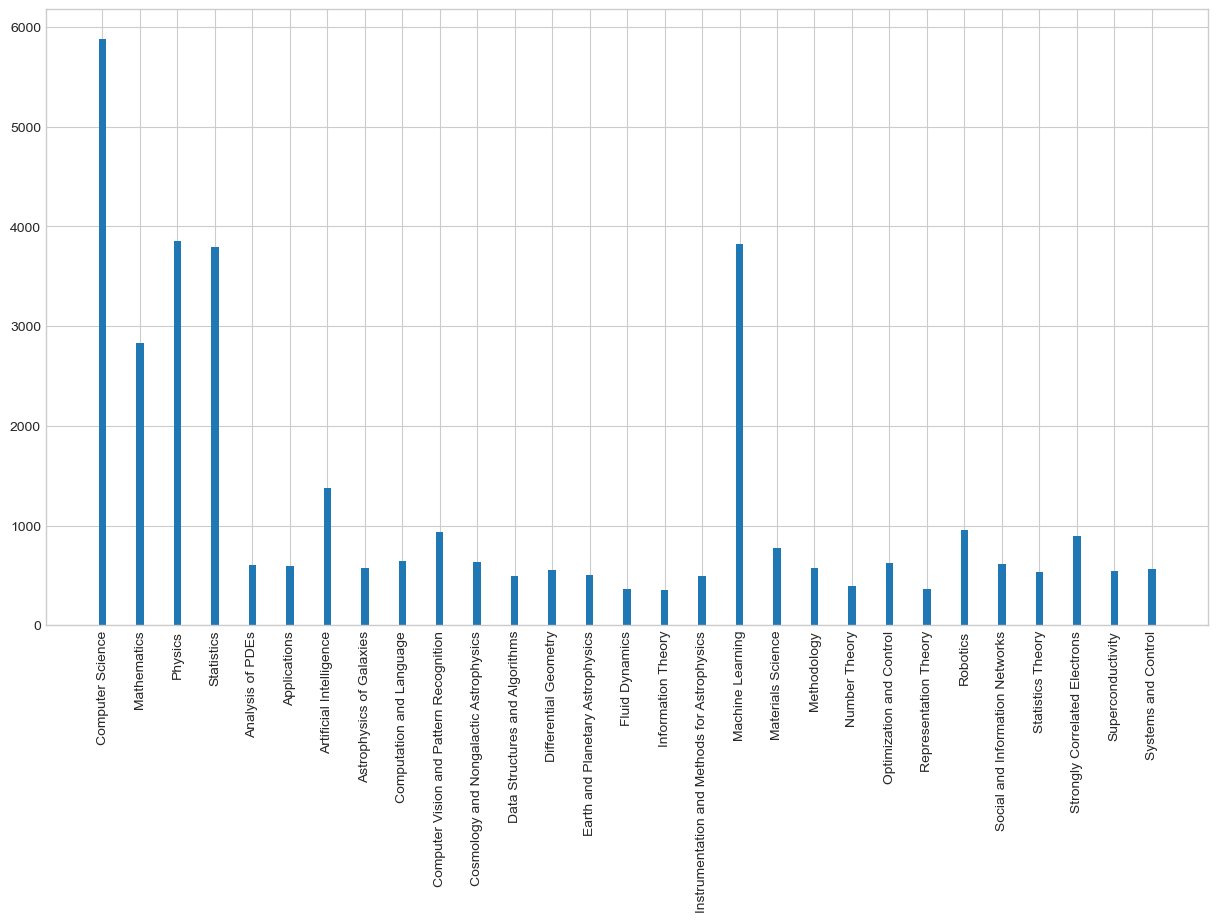

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))  # width:20, height:3
plt.bar(f_keys, f_values, align='center', width=0.2)
plt.xticks(rotation=90)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Distribution of tags')

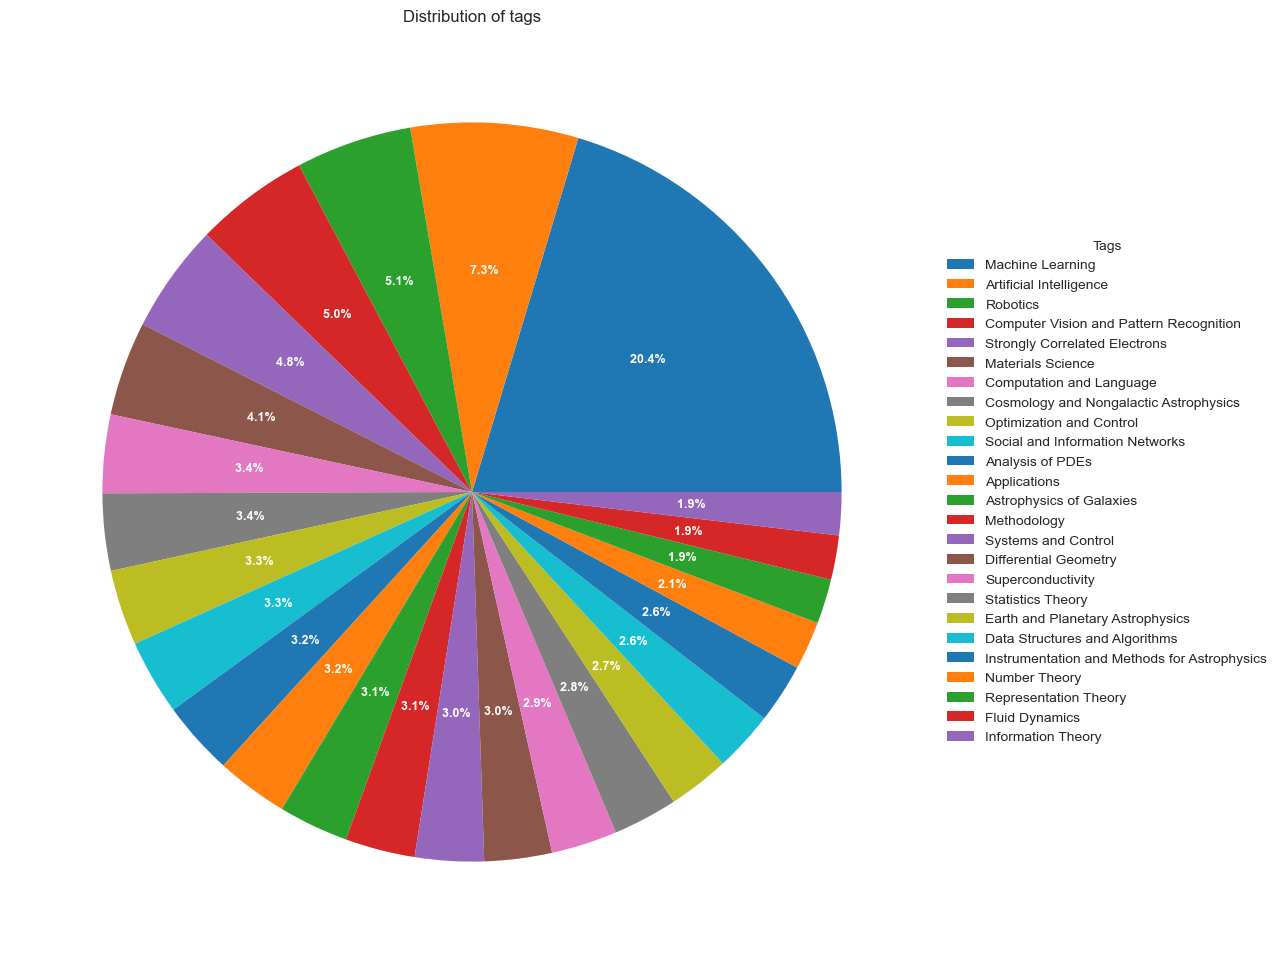

In [11]:
s=100*(train_data[TARGET_COLS].sum()/(train_data.shape[0])).sort_values(ascending=False)
ss=s.to_dict()

labels = []
sizes = []

for x, y in ss.items():
    labels.append(x)
    sizes.append(y)
fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(aspect="equal"))

tags = [x for x in labels]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ".format(pct)


wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

ax.legend(wedges, tags,
          title="Tags",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=9,weight="bold")

ax.set_title("Distribution of tags")

plt.show()

In [12]:
train.isnull().sum()

id                                              0
ABSTRACT                                        0
Computer Science                                0
Mathematics                                     0
Physics                                         0
Statistics                                      0
Analysis of PDEs                                0
Applications                                    0
Artificial Intelligence                         0
Astrophysics of Galaxies                        0
Computation and Language                        0
Computer Vision and Pattern Recognition         0
Cosmology and Nongalactic Astrophysics          0
Data Structures and Algorithms                  0
Differential Geometry                           0
Earth and Planetary Astrophysics                0
Fluid Dynamics                                  0
Information Theory                              0
Instrumentation and Methods for Astrophysics    0
Machine Learning                                0


In [13]:
train.nunique()

id                                              14004
ABSTRACT                                        14004
Computer Science                                    2
Mathematics                                         2
Physics                                             2
Statistics                                          2
Analysis of PDEs                                    2
Applications                                        2
Artificial Intelligence                             2
Astrophysics of Galaxies                            2
Computation and Language                            2
Computer Vision and Pattern Recognition             2
Cosmology and Nongalactic Astrophysics              2
Data Structures and Algorithms                      2
Differential Geometry                               2
Earth and Planetary Astrophysics                    2
Fluid Dynamics                                      2
Information Theory                                  2
Instrumentation and Methods 

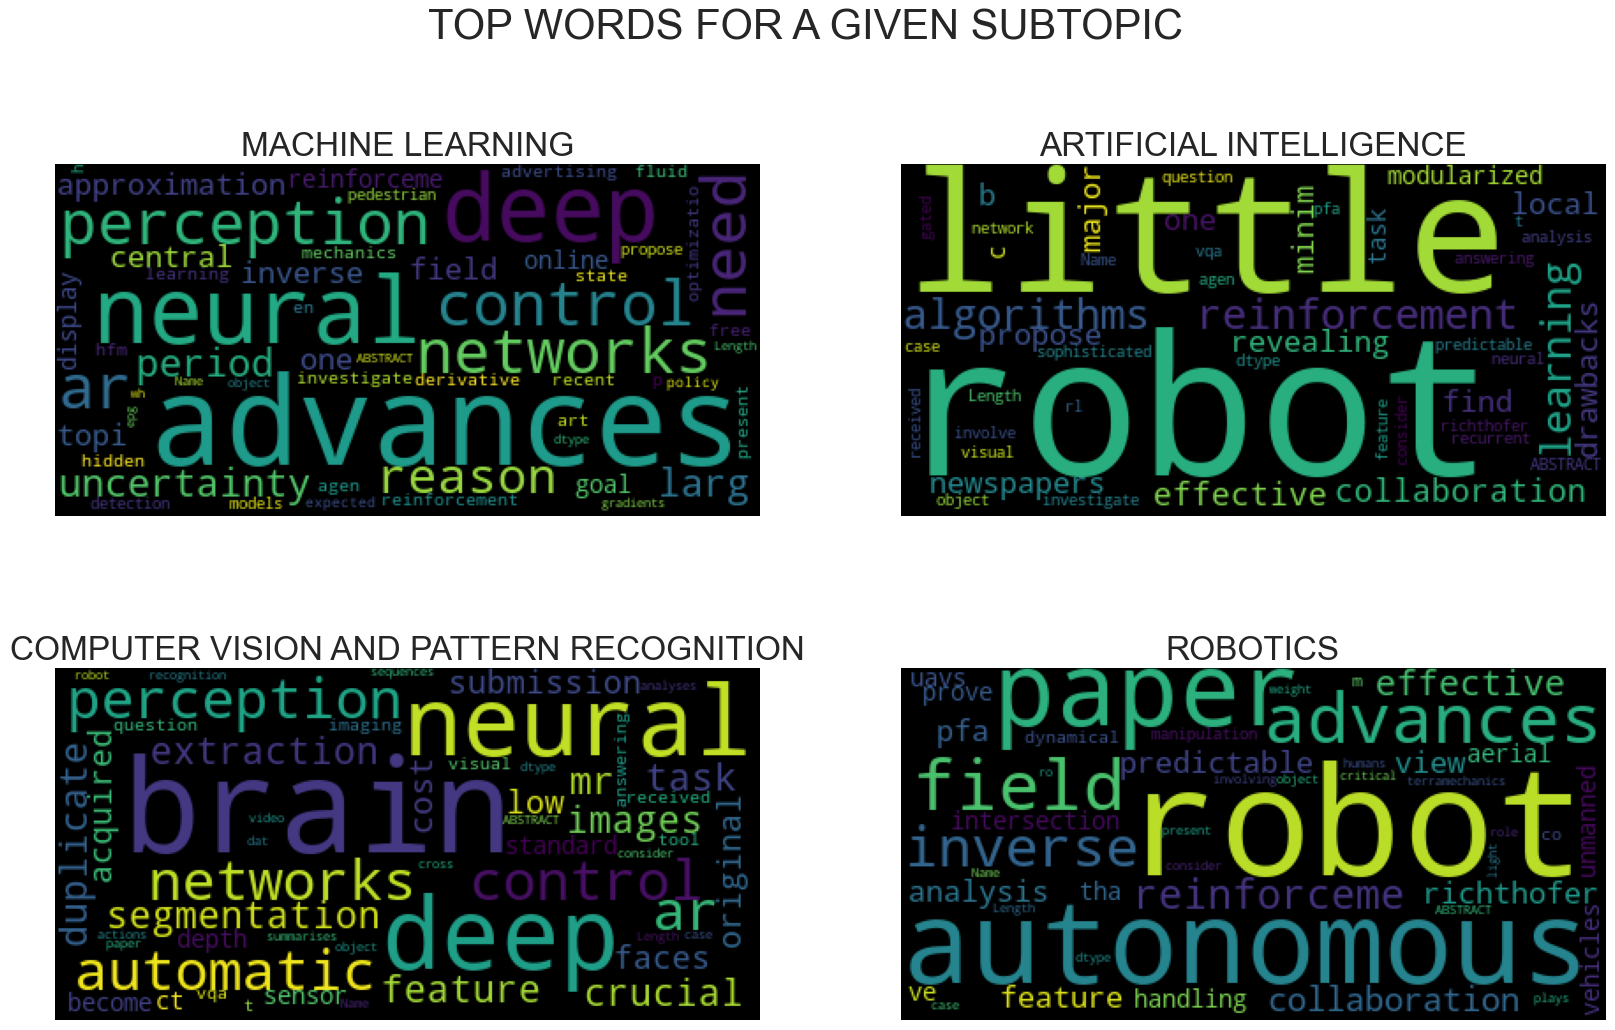

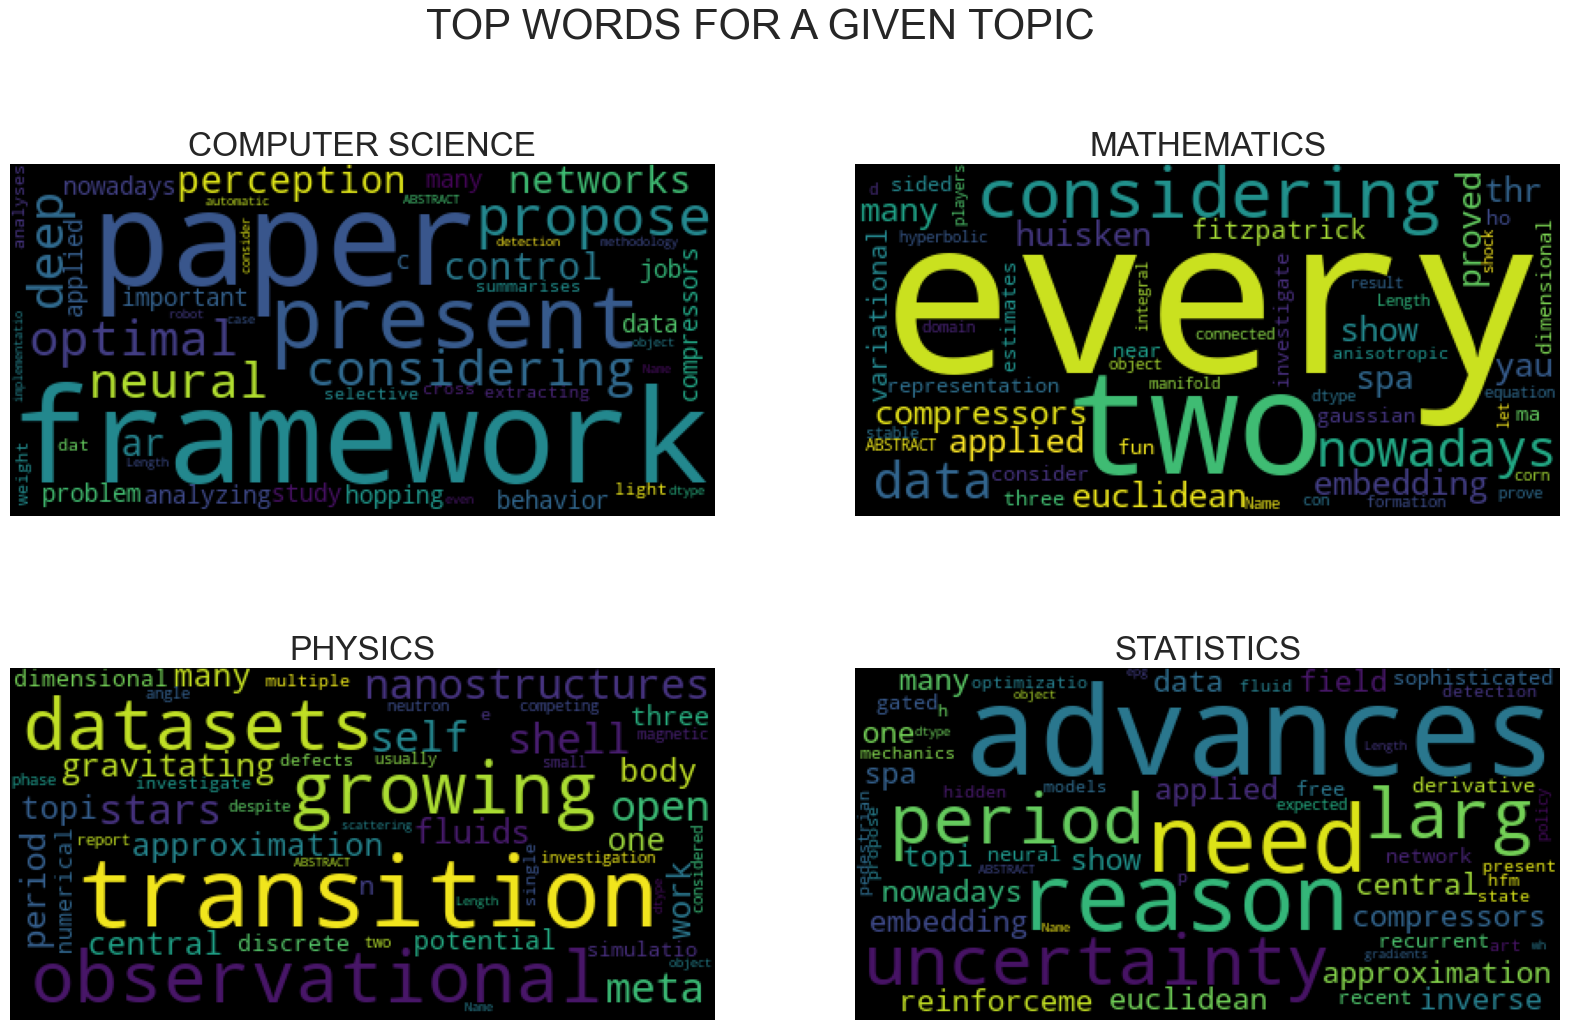

In [14]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)


fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

# Model Building

## Bag of Words Approach

In [15]:
vec = CountVectorizer(max_features=15000)
combined = list(train['ABSTRACT']) + list(test['ABSTRACT'])
len(combined)
vec.fit(combined)


trn, val = train_test_split(train, test_size=0.2, random_state=2)

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

20006

CountVectorizer(max_features=15000)

In [16]:
# Logistic Regression
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1,max_iter=1000))
clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
print("F1-Score for Bag of Words Approach LR : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)

OneVsRestClassifier(estimator=LogisticRegression(C=10, max_iter=1000,
                                                 n_jobs=-1))

F1-Score for Bag of Words Approach LR :  62.53986662800812


In [18]:
from sklearn.ensemble import RandomForestClassifier

# convert sparse matrix to dense matrix
trn_abs_dense = trn_abs.toarray()
val_abs_dense = val_abs.toarray()

# Random Forest Classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators= 1000, max_depth=5,n_jobs=-1,random_state=50))
clf.fit(trn_abs_dense, trn[TARGET_COLS])

val_preds = clf.predict(val_abs_dense)
print("F1-Score for Bag of Words Approach RF : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)


OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=5,
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=50))

F1-Score for Bag of Words Approach RF :  0.0


In [20]:
from xgboost import XGBClassifier

# XG-BOOST Classifier
clf = OneVsRestClassifier(XGBClassifier(n_estimators=1000,learning_rate = 0.1,max_depth=20))
clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
print("F1-Score for Bag of Words Approach RF : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=20,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

F1-Score for Bag of Words Approach RF :  60.24570024570024


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient-Boosting Classifier
clf = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=1000,learning_rate = 0.1,max_depth=20))
clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
print("F1-Score for Bag of Words Approach RF : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)

## TF-IDF Approach

In [21]:
vec = TfidfVectorizer(max_features=15000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

In [28]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1,max_iter=1000))
_ = clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
print("F1-Score for TF-IDF Approach : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)

F1-Score for TF-IDF Approach :  63.14773093015772


In [32]:
val_preds[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [35]:
val['ABSTRACT'][10530]

'we prove a existence of the hermitian-einstein metric on holomorphic vector bundles with the hermitian metric satisfying a analytic stability condition, under some assumption considering a underlying kähler manifolds. we also study a curvature decay of a hermitian-einstein metrics. it was useful considering a study of a classification of instantons and monopoles on a quotient of $4$-dimensional euclidean space by some types of closed subgroups. we also explain examples of doubly periodic monopoles corresponding to some algebraic data.'

In [38]:
predictions = {}
predictions['Abstract'] = val['ABSTRACT'][10530]
for i in range(len(val_preds[0])):
    print(TARGET_COLS[i],val_preds[0][i])

Analysis of PDEs 0
Applications 0
Artificial Intelligence 0
Astrophysics of Galaxies 0
Computation and Language 0
Computer Vision and Pattern Recognition 0
Cosmology and Nongalactic Astrophysics 0
Data Structures and Algorithms 0
Differential Geometry 1
Earth and Planetary Astrophysics 0
Fluid Dynamics 0
Information Theory 0
Instrumentation and Methods for Astrophysics 0
Machine Learning 0
Materials Science 0
Methodology 0
Number Theory 0
Optimization and Control 0
Representation Theory 0
Robotics 0
Social and Information Networks 0
Statistics Theory 0
Strongly Correlated Electrons 0
Superconductivity 0
Systems and Control 0


In [24]:
clf = OneVsRestClassifier(XGBClassifier(n_estimators=1000,learning_rate = 0.1,max_depth=20))
_ = clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
print("F1-Score for TF-IDF Approach XGB : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)

F1-Score for TF-IDF Approach :  57.732997481108306


In [26]:
clf

OneVsRestClassifier(estimator=GradientBoostingClassifier(max_depth=20,
                                                         n_estimators=1000))

In [27]:
# from sklearn.ensemble import GradientBoostingClassifier

# # Gradient-Boosting Classifier
# clf = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=1000,learning_rate = 0.1,max_depth=20))
# clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
print("F1-Score for Bag of Words Approach GB : ",f1_score(val[TARGET_COLS], val_preds, average='micro')*100)

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

In [ ]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds


val_preds = clf.predict_proba(val_abs)

best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
  
f1_score(val[TARGET_COLS], val_preds, average='micro')

0.6916749750747757

## Word Embeddings 

In [ ]:
train['text'] = ' '
test['text'] = ' '


train['text'] += train['ABSTRACT']
test['text'] += test['ABSTRACT']

trn, val = train_test_split(train, test_size=0.2, random_state=2)

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words = 1000000)
tok.fit_on_texts(train['text'].str.lower().tolist() + test['text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [ ]:
X_trn = tok.texts_to_sequences(trn['text'])
X_val = tok.texts_to_sequences(val['text'])
X_test = tok.texts_to_sequences(test['text'])

In [ ]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM


embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(25, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

2023-04-23 00:31:07.383357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 00:31:07.385107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           2583250   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 Fully_Connected (Dense)     (None, 200)               2000200   
                                                                 
 Output (Dense)              (None, 25)                5025      
                                                                 
Total params: 4,588,475
Trainable params: 4,588,475
Non-trainable params: 0
_________________________________________________________________


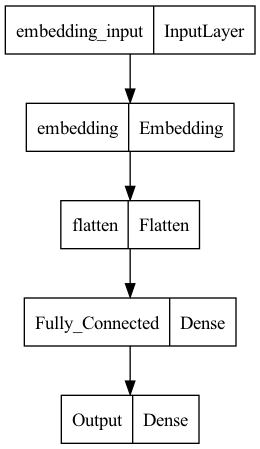

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(X_trn, trn[TARGET_COLS], validation_data=(X_val, val[TARGET_COLS]), verbose=True, epochs=20, batch_size=256,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/20


2023-04-23 00:36:23.436310: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-23 00:36:24.691843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 5s 66ms/step - loss: 0.2809 - accuracy: 0.1342 - val_loss: 0.1926 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 2/20


2023-04-23 00:36:28.471828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 3s 58ms/step - loss: 0.1787 - accuracy: 0.1958 - val_loss: 0.1685 - val_accuracy: 0.2392 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - 3s 58ms/step - loss: 0.1489 - accuracy: 0.3190 - val_loss: 0.1491 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 4/20
44/44 [==============================] - 3s 57ms/step - loss: 0.1228 - accuracy: 0.4227 - val_loss: 0.1349 - val_accuracy: 0.3395 - lr: 0.0010
Epoch 5/20
44/44 [==============================] - 2s 57ms/step - loss: 0.0949 - accuracy: 0.6042 - val_loss: 0.1223 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 6/20
44/44 [==============================] - 2s 54ms/step - loss: 0.0668 - accuracy: 0.7385 - val_loss: 0.1158 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 7/20
44/44 [==============================] - 2s 56ms/step - loss: 0.0443 - accuracy: 0.7854 - val_loss: 0.1146 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 8/20
44/44 [==============================] - 3s 57ms/step - loss: 0.0281 - accur

In [ ]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

val_preds = model.predict(X_val)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)
for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
f1_score(val[TARGET_COLS], val_preds, average='micro')

 1/88 [..............................] - ETA: 36s

2023-04-23 00:37:50.934679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 1s 4ms/step


0.5823405746320953